In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygmsh

In [2]:
class Face:
    points = None #points in the face
    triangleIndex = None #an array containing the index of the triangles that share this face, if face is on boundary then triangleIndex[1] = -1 ]
    Tau = None
    d = None #the value of d, as calculated in assignment 
    m = None #length of this face
    
    def __init__(self, points, triangleIndex) : #constructor
        self.points = points
        self.triangleIndex = np.array([triangleIndex,-1])
        self.m = dist(points[0], points[1])

    def calcTau(self, triangleMesh) : #calculate the value of d
        if(self.triangleIndex[1] == -1) : #this case is for when the face is on the boundar
            xK = triangleMesh[self.triangleIndex[0]].centroid
            #d should be the shortest distance from xK to the line that is this face, as ysigma should be the point on the line that fufils this
            self.d = np.abs((self.points[1][0] - self.points[0][0])*(self.points[0][1] - xK[1])- (self.points[0][0] - xK[0])*(self.points[1][1] - self.points[0][1]))/dist(self.points[0],self.points[1]) 
            self.Tau= self.m/self.d
        else : #do this if face is an interior
            xK = triangleMesh[self.triangleIndex[0]].centroid
            xL = triangleMesh[self.triangleIndex[1]].centroid
            self.d = dist(xK,xL)
            self.Tau= self.m/self.d
    
    def sameFace(self, otherFace) : #checks if two faces represent the same face
        t = (np.all(self.points[0] == otherFace.points[0]) and np.all(self.points[1] == otherFace.points[1])) or (np.all(self.points[1] == otherFace.points[0]) and np.all(self.points[0] == otherFace.points[1]))
        return t
    

class Triangle :
    points = None #the three points of a triangle
    centroid = None #the centroid 
    Faces = None #the three faces of the triangle
    index = None #the index of the triangle
    m = None #the area of the triangle
    
    def __init__(self, points, index) :
        self.points = points
        
        #calculate the centroid using cartesian coordinates as shown in https://en.wikipedia.org/wiki/Circumcircle 
        D = 2*(points[0][0]*(points[1][1] - points[2][1]) + points[1][0]*(points[2][1] - points[0][1]) + points[2][0]*(points[0][1] - points[1][1]))
        self.centroid = 1/D * np.array([(magnitude(points[0])**2)*(points[1][1]-points[2][1]) + (magnitude(points[1])**2)*(points[2][1]-points[0][1]) + (magnitude(points[2])**2)*(points[0][1]-points[1][1]),
                                           (magnitude(points[0])**2)*(points[2][0]-points[1][0]) + (magnitude(points[1])**2)*(points[0][0]-points[2][0]) + (magnitude(points[2])**2)*(points[1][0]-points[0][0])])
        
        #self.centrePoint = (points[0]+points[1]+points[2])/3
        self.index = index
        self.Faces = np.empty(shape = 3, dtype = Face)
        self.Faces[0] = Face(np.array([points[0], points[1]]),index)
        self.Faces[1] = Face(np.array([points[1], points[2]]),index)
        self.Faces[2] = Face(np.array([points[2], points[0]]),index)
        #calculate mass of triangle using Heron's formula
        self.m = 0.5*np.abs(points[0][0]*(points[1][1] - points[2][1]) + points[1][0]*(points[2][1] - points[0][1]) + points[2][0]*(points[0][1] - points[1][1]))
    
    def setIndex(self, index) : #method for changing the index of the triangle and the faces triangleIndex
        self.index = index
        for edge in self.Faces :
            edge.triangleIndex[0] = index
            
        
    def draw(self) : #method for plotting this triangle
        X = [self.points[0][0],self.points[1][0], self.points[2][0], self.points[0][0]]
        Y = [self.points[0][1],self.points[1][1], self.points[2][1], self.points[0][1]]
        plt.plot(X,Y, marker = 'o', color = 'black')
        plt.plot(self.centroid[0], self.centroid[1], marker = 'o', color = 'red')
        #fig = plt.gcf()
        #ax = fig.gca()
        #ax.add_patch(plt.Circle(self.centrePoint, dist(self.centrePoint,self.points[1]), color='b', fill = False))
        #fig.axes().set_aspect('equal')
        
    def InCircumScribedCircle(self,point) : #this method (used in the bowyer-watson algorithm) checks if a point lies in this triangles circumcircle, the algorithm comes from https://en.wikipedia.org/wiki/Delaunay_triangulation
        testMatrix = np.array([[self.points[0][0],self.points[0][1], self.points[0][0]**2 + self.points[0][1]**2,1],
                  [self.points[1][0],self.points[1][1], self.points[1][0]**2 + self.points[1][1]**2,1],
                  [self.points[2][0],self.points[2][1], self.points[2][0]**2 + self.points[2][1]**2,1],
                  [point[0],point[1], point[0]**2 + point[1]**2,1]])
        return np.linalg.det(testMatrix) > 0


In [3]:
#DISTANCE FUNCTION
def dist(point1, point2) :
    return np.sqrt((point1[0] - point2[0])**2+(point1[1] - point2[1])**2)

def magnitude(point) : #calculates magnitude of a point
    return dist(point, np.array([0,0]))

def orderCounterClockwise(points) : #order three points counterclockwise
    cpoint = (points[0]+points[1]+points[2])/3
    angles = np.zeros(3) 
    for i in range(0,3):  #calculate angles theta value in polar coordinates for each vertex of the triangle recentred at origin
        angles[i] = np.arctan2(points[i][1] - cpoint[1],points[i][0]-cpoint[0])                    
    
    swap = True
    order = np.array(range(0,3))
    
    while swap : #bubble sort to sort in order of increasing theta
        swap = False
        for i in range(0,2) :
            if(angles[i]  > angles[i+1]) :
                tempAngle = angles[i] 
                tempPoint = order[i]
                angles[i] = angles[i+1]
                order[i] = order[i+1]
                angles[i+1] = tempAngle
                order[i+1] = tempPoint
                swap = True
    
    return np.array( [points[order[0]],points[order[1]], points[order[2]]])
    
def pltTriangulation(triangulation): #plots a triangulation
    for i in range(0, len(triangulation)) :
            triangulation[i].draw()

    return plt.gcf()
    #fig.axes().set_aspect('equal')
    #fig.xlim((0,1))
    #fig.ylim((0,1))

In [4]:
#implementation of Bowyer-Watson algorithm https://en.wikipedia.org/wiki/Bowyer%E2%80%93Watson_algorithm
#this creates Delauney Triangulations which is an admissible mesh

def BowyerWatson(points): 
    triangulation = np.empty(shape = 1, dtype = Triangle)
    superTriangle = Triangle(np.array([[-4,-2],[4,-2], [0,4]]),0) #makeSuperTriangle
    triangulation[0] = superTriangle
    index = 1
    
    for i in range(0,len(points)) :


        currentPoint = points[i]
        badTriangles = np.empty(shape = 0, dtype = Triangle)

        for T in triangulation : #find badTriangles - triangles that break the Delauney condition
            if(T.InCircumScribedCircle(currentPoint)) :
                badTriangles = np.append(badTriangles,T)

        polygon = np.empty(shape = 0, dtype = Face)


        for T in badTriangles :
            for edge in T.Faces :
                sharedFace = False
                for T2 in badTriangles :
                    if(T2.index != T.index) :
                        for edge2 in T2.Faces:
                            if(edge.sameFace(edge2)):
                                sharedFace = True
                if(not sharedFace) :
                    polygon = np.append(polygon, edge) 

        for T in badTriangles :
            #print('bad triangle :',T.points )
            for k in range(0,len(triangulation)) :
                if(T == triangulation[k]):
                    triangulation = np.delete(triangulation, k)
                    break

        for edge in polygon :
            newPoints = orderCounterClockwise(np.array([edge.points[0], edge.points[1], currentPoint]))
            triangulation = np.append(triangulation, Triangle(newPoints, index))
            index+=1


    #return triangulation
    finalTriangulation = np.empty(shape = 0, dtype = Triangle)
    for T in triangulation :
        addTriangle = True
        for k in range(0,3) :
            for l in range(0,3) :
                if(np.all(T.points[k] == superTriangle.points[l])):
                    addTriangle = False
                    #print(T.points)
                    break
        if(addTriangle) :
            finalTriangulation = np.append(finalTriangulation,T)
    
    #THIS COMPLETES BOWYER-WATSON ALGORTIHM, The following code is to 
    for k in range(0,len(finalTriangulation)):
        finalTriangulation[k].setIndex(k)
        
    for T1 in finalTriangulation :
        for T2 in finalTriangulation :
            if(T1 != T2) :
                for edge1 in T1.Faces :
                    for edge2 in T2.Faces :
                        if(edge1.sameFace(edge2)) :
                            edge1.triangleIndex[1] = T2.index
    for T in finalTriangulation :
        for edge in T.Faces :
            edge.calcTau(finalTriangulation)
    return finalTriangulation


In [5]:
def generateRandomMesh(size) :
    with pygmsh.geo.Geometry() as geom:
        geom.add_polygon(
            [
                [0.0, 0.0],
                [1.0, 0.0],
                [1.0, 1.0],
                [0.0, 1.0],
            ],
            mesh_size=size,
        )
        mesh = geom.generate_mesh()
        return mesh.points[:,0:2] 


In [6]:
points = generateRandomMesh(0.15)
        
triangulation = BowyerWatson(points)

#print(len(points))

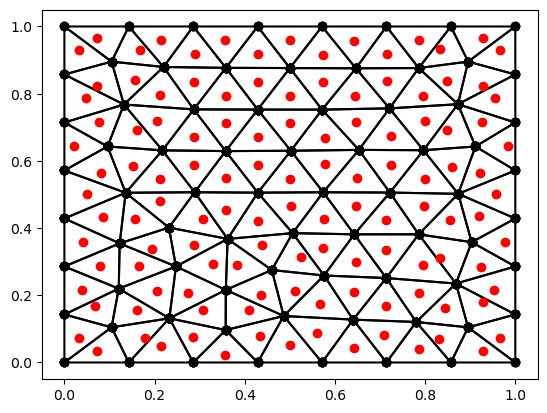

In [7]:
#DISPLAY TRIANGULATION 
fig = pltTriangulation(triangulation)



In [8]:
def f(point) : #our f
    return  6*point[0]*point[1]*(1-point[1])-2*point[0]**3

In [9]:
# Calculating A and B

A = np.zeros((len(triangulation),len(triangulation)))
B = np.zeros(len(triangulation))


for i in range(len(triangulation)):
    B[i] = triangulation[i].m*f(triangulation[i].centroid)
    for edge in triangulation[i].Faces :
        if( edge.triangleIndex[1] != -1) :
            A[i,i] += -edge.Tau
            A[i, edge.triangleIndex[1]] = edge.Tau
        else :
            A[i,i] += edge.Tau
U = np.linalg.solve(A,B)

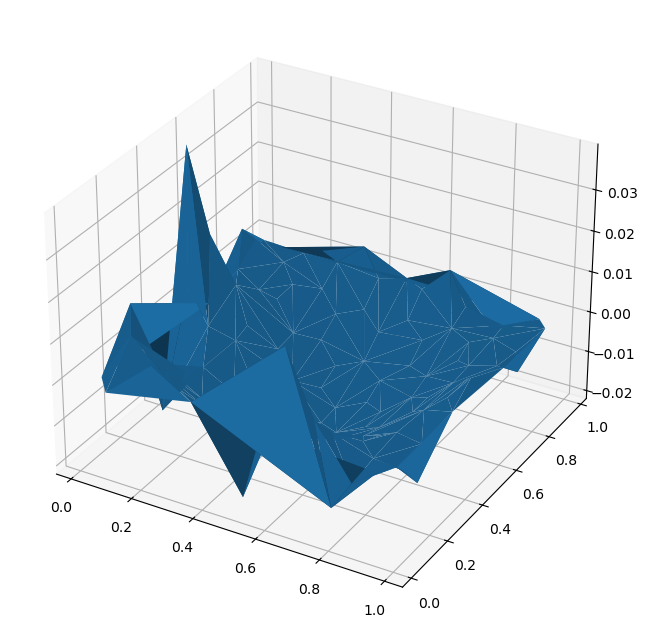

In [10]:
#3D plot U
X = np.zeros(len(triangulation))
Y = np.zeros(len(triangulation))
for i in range(len(triangulation)):
    
    X[i] = triangulation[i].centroid[0]
    Y[i] = triangulation[i].centroid[1]
    
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
surf = ax.plot_trisurf(X, Y, U, linewidth=0)# antialiased=False)
ax.set_title('')
plt.show()